In [ ]:
import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing the dataset

df = pd.read_csv('Tweets.csv', header=0)
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative



Inference: The Datset consists of 2 features & 16436 samples.


In [ ]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16436 entries, 0 to 16435
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       16435 non-null  object
 1   sentiment  16435 non-null  object
dtypes: object(2)
memory usage: 256.9+ KB


In [ ]:
#Checking the stats of all the columns

display(df.describe())

,text,sentiment
count,16435,16435
unique,16435,3
top,"I`d have responded, if I were going",neutral
freq,1,6671


In [ ]:
#Check for empty elements

print(df.isnull().sum())

text         1
sentiment    1
dtype: int64


In [ ]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [ ]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [ ]:

import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


In [ ]:
 import nltk
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

#with Pool(4) as p:
#    df['text'] = list(tqdm(p.imap(preprocessor, range(df.shape[0]))))
for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])


df.head()

100%|██████████| 16434/16434 [00:32<00:00, 500.07it/s]


,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put releas alreadi bought,negative


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df[target].values
x=tfidf.fit_transform(df.text)

            Target Variable Distribution           


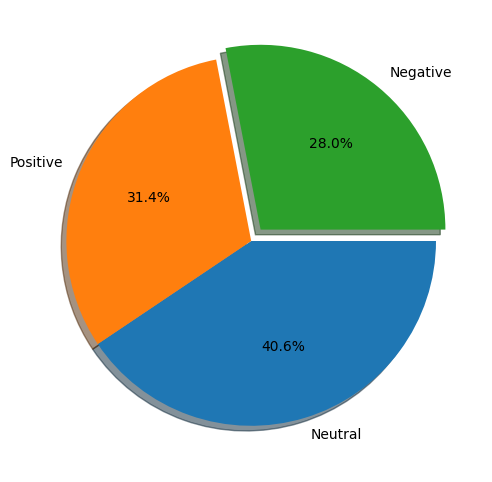

In [ ]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True,
        explode=[0,0,0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

100%|██████████| 16434/16434 [00:05<00:00, 2799.04it/s]


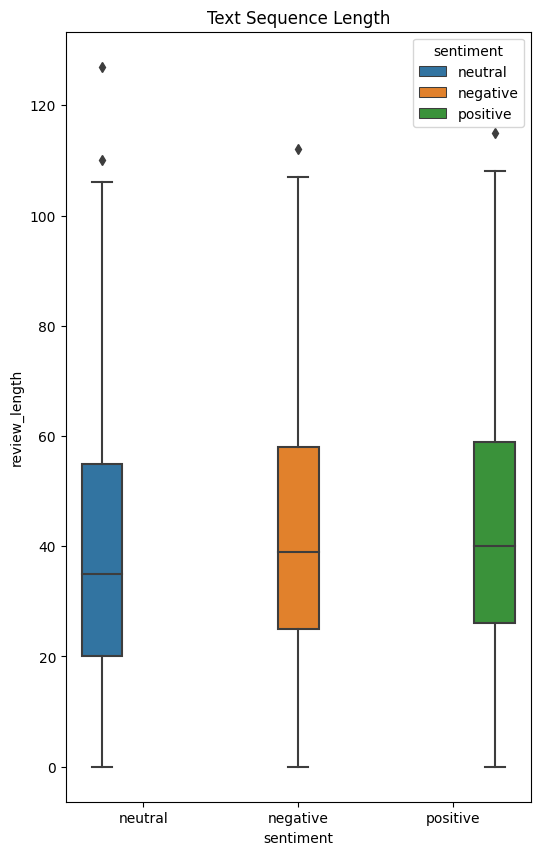

In [ ]:
# Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[6,10])
sns.boxplot(x=target,y='review_length', data=df2, hue=target)
plt.title('Text Sequence Length')
plt.show()

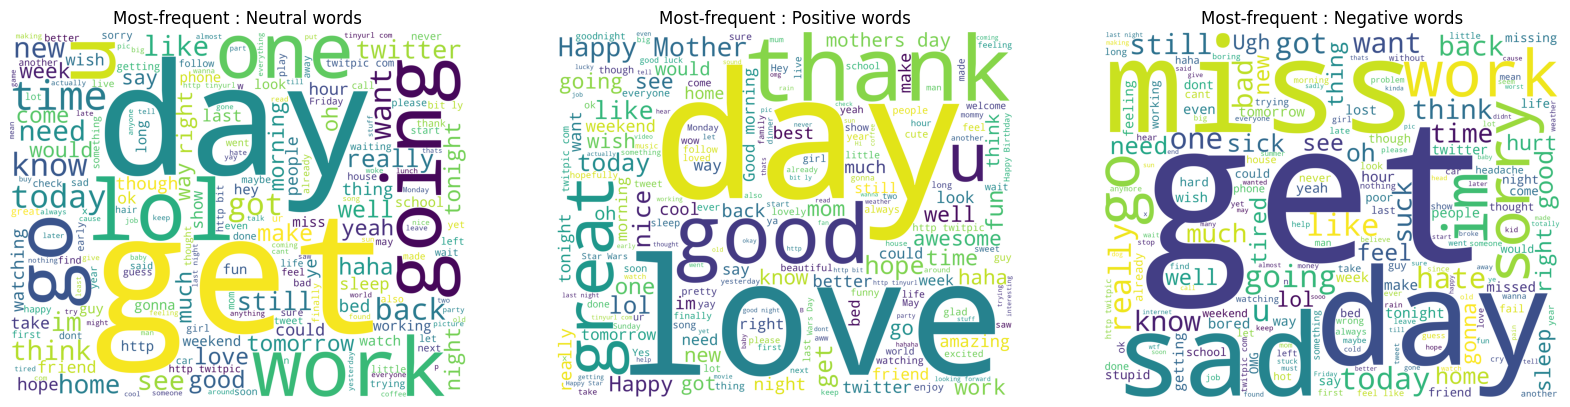

In [ ]:
neutraldata = original_df[original_df[target]=='neutral']
neutraldata= neutraldata['text']
positivedata = original_df[original_df[target]=='positive']
positivedata =positivedata['text']
negdata = original_df[original_df[target]== 'negative']
negdata = negdata['text']


def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neutraldata,'white','Most-frequent : Neutral words')

plt.subplot(1,3,2)
wordcloud_draw(positivedata,'white','Most-frequent : Positive words')

plt.subplot(1,3,3)
wordcloud_draw(negdata, 'white','Most-frequent : Negative words')
plt.show()

In [ ]:
MAP={'negative':0, 'neutral':1, 'positive':2}
df.sentiment = df.sentiment.map(MAP)

In [ ]:
#Splitting the data intro training & testing sets

X = x
Y = pd.Series(y).map(MAP)
MAP={'negative':0, 'neutral':1, 'positive':2}
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,len(Y),'\nTraining set  ---> ',Train_X.shape,len(Train_Y),'\nTesting set   ---> ', Test_X.shape,'', len(Test_Y))

Original set  --->  (16434, 16196) 16434 
Training set  --->  (13147, 16196) 13147 
Testing set   --->  (3287, 16196)  3287


In [ ]:
#Let us create first create a table to store the results of various models

Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
#Let us define functions to summarise the Prediction's scores .

from scikitplot.metrics import plot_roc_curve as auc_roc

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))

    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 63.6%
F1 Score = 63.5%

 Confusiton Matrix:
 [[502 329  97]
 [241 856 216]
 [ 81 234 731]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.54      0.57       928
           1       0.60      0.65      0.63      1313
           2       0.70      0.70      0.70      1046

    accuracy                           0.64      3287
   macro avg       0.64      0.63      0.63      3287
weighted avg       0.64      0.64      0.63      3287



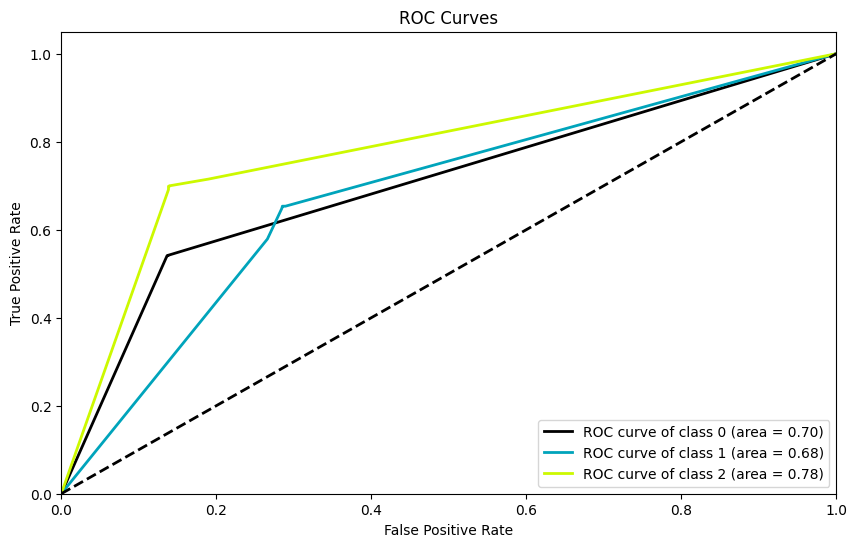

In [ ]:
DT_model = DecisionTreeClassifier()
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred, pred_prob, 1)


In [ ]:
def map_predictions_to_labels(predictions):
    reverse_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return [reverse_MAP[pred] for pred in predictions]

pred_labels = map_predictions_to_labels(pred)


start_index = 0
end_index = 10

# Print the original tweets along with the original and predicted sentiment labels for the specified range of tweets
for i in range(start_index, min(end_index, len(Test_Y))):
    original_sentiment = reverse_MAP[Test_Y.iloc[i]]
    predicted_sentiment = pred_labels[i]
    original_tweet = original_df.iloc[i]['text']

    print(f"Tweet {i+1}:")
    print(f"Original Sentiment: {original_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Original Tweet: {original_tweet}\n")




Tweet 1:
Original Sentiment: positive
Predicted Sentiment: positive
Original Tweet:  I`d have responded, if I were going

Tweet 2:
Original Sentiment: positive
Predicted Sentiment: positive
Original Tweet:  Sooo SAD I will miss you here in San Diego!!!

Tweet 3:
Original Sentiment: neutral
Predicted Sentiment: neutral
Original Tweet: my boss is bullying me...

Tweet 4:
Original Sentiment: neutral
Predicted Sentiment: neutral
Original Tweet:  what interview! leave me alone

Tweet 5:
Original Sentiment: neutral
Predicted Sentiment: negative
Original Tweet:  Sons of ****, why couldn`t they put them on the releases we already bought

Tweet 6:
Original Sentiment: negative
Predicted Sentiment: neutral
Original Tweet: http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth

Tweet 7:
Original Sentiment: neutral
Predicted Sentiment: positive
Original Tweet: 2am feedings for the baby are fun when he is all smiles and coos

Tweet 8:
Original Sentiment: neutral

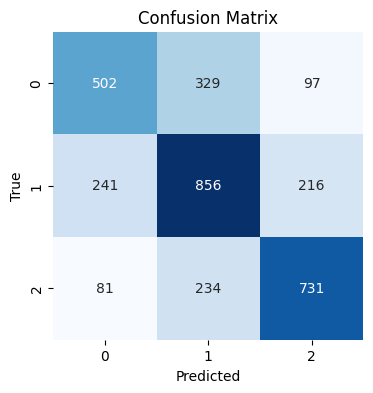

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

conf_matrix = confusion_matrix(Test_Y, pred)
plot_confusion_matrix(conf_matrix)

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate training accuracy
train_accuracy = accuracy_score(Train_Y, DT.predict(Train_X))

# Calculate test accuracy
test_accuracy = accuracy_score(Test_Y, pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 99.79%
Test Accuracy: 63.55%


<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 68.4%
F1 Score = 68.2%

 Confusiton Matrix:
 [[489 375  64]
 [148 995 170]
 [ 40 242 764]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.53      0.61       928
           1       0.62      0.76      0.68      1313
           2       0.77      0.73      0.75      1046

    accuracy                           0.68      3287
   macro avg       0.70      0.67      0.68      3287
weighted avg       0.69      0.68      0.68      3287



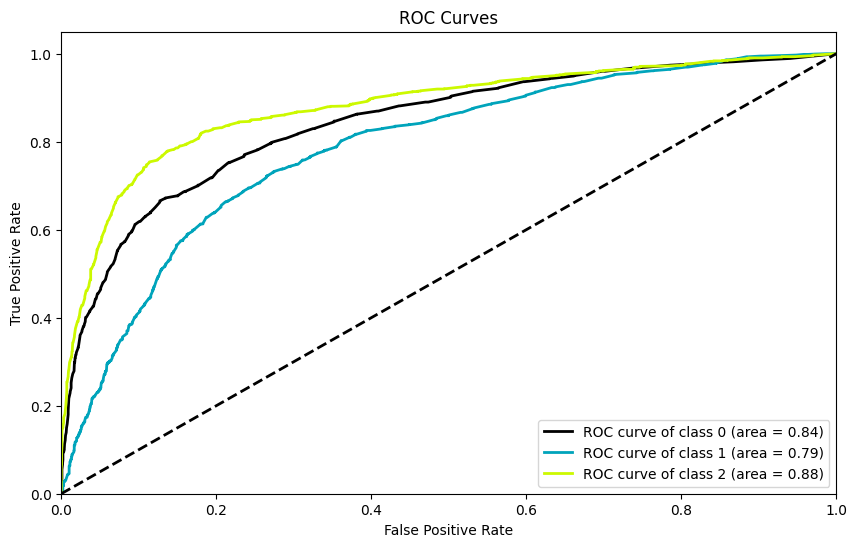

In [ ]:
RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X, Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,2)

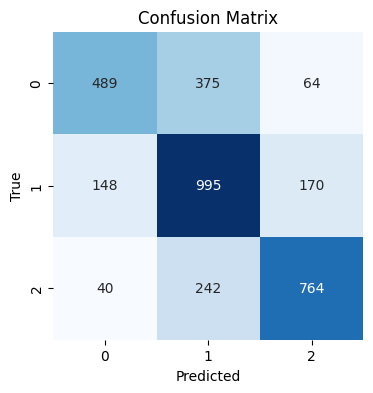

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

conf_matrix = confusion_matrix(Test_Y, pred)
plot_confusion_matrix(conf_matrix)


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have already trained your Decision Tree model 'DT' and made predictions 'pred' on both training and test data

# Calculate training accuracy
train_accuracy = accuracy_score(Train_Y, RF.predict(Train_X))

# Calculate test accuracy
test_accuracy = accuracy_score(Test_Y, pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 99.79%
Test Accuracy: 69.14%


In [ ]:
def map_predictions_to_labels(predictions):
    reverse_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return [reverse_MAP[pred] for pred in predictions]

pred_labels = map_predictions_to_labels(pred)


start_index = 0
end_index = 10

# Print the original tweets along with the original and predicted sentiment labels for the specified range of tweets
for i in range(start_index, min(end_index, len(Test_Y))):
    original_sentiment = reverse_MAP[Test_Y.iloc[i]]
    predicted_sentiment = pred_labels[i]
    original_tweet = original_df.iloc[i]['text']

    print(f"Tweet {i+1}:")
    print(f"Original Sentiment: {original_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Original Tweet: {original_tweet}\n")


Tweet 1:
Original Sentiment: positive
Predicted Sentiment: positive
Original Tweet:  I`d have responded, if I were going

Tweet 2:
Original Sentiment: positive
Predicted Sentiment: positive
Original Tweet:  Sooo SAD I will miss you here in San Diego!!!

Tweet 3:
Original Sentiment: neutral
Predicted Sentiment: neutral
Original Tweet: my boss is bullying me...

Tweet 4:
Original Sentiment: neutral
Predicted Sentiment: neutral
Original Tweet:  what interview! leave me alone

Tweet 5:
Original Sentiment: neutral
Predicted Sentiment: neutral
Original Tweet:  Sons of ****, why couldn`t they put them on the releases we already bought

Tweet 6:
Original Sentiment: negative
Predicted Sentiment: neutral
Original Tweet: http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth

Tweet 7:
Original Sentiment: neutral
Predicted Sentiment: positive
Original Tweet: 2am feedings for the baby are fun when he is all smiles and coos

Tweet 8:
Original Sentiment: neutral
